ToDo
- Дописать бейзлайн и обучить модельку.
- Попробовать использовать LLM + Ранжирование

LangGraph

In [ ]:
# base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных (colab)

In [ ]:
import gdown

url = "https://drive.google.com/file/d/1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B/view?usp=sharing"
output = "data.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B
From (redirected): https://drive.google.com/uc?id=1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B&confirm=t&uuid=39008da4-abdb-4a97-b9fb-2552dd05dd98
To: /content/data.zip
100%|██████████| 26.6M/26.6M [00:00<00:00, 83.1MB/s]


'data.zip'

In [ ]:
!mkdir data
!mkdir data/raw

In [ ]:
!unzip data.zip -d data/raw

Archive:  data.zip
  inflating: data/raw/data_final_for_dls_new.jsonl  
  inflating: data/raw/data_final_for_dls_eval_new.jsonl  


In [ ]:
!rm data.zip

In [ ]:
data_eval = pd.read_json("data/raw/data_final_for_dls_eval_new.jsonl", lines=True)
data = pd.read_json("data/raw/data_final_for_dls_new.jsonl", lines=True)

data.drop(columns='relevance', inplace=True)
data_eval.drop(columns='relevance', inplace=True)

data.rename(columns={'relevance_new': 'relevance'}, inplace=True)
data_eval.rename(columns={'relevance_new': 'relevance'}, inplace=True)

# 0. Проведем небольшой EDA


In [ ]:
data.sample(5)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
21683,нужны рекрутеры для поиска девушки,"Новосибирск, улица Ленина, 3",Серьезные знакомства; Serious Dating; Два Сердца,Служба знакомств,1216827787,"Предлагает услуги для серьёзных знакомств, вкл...",Организация занимается помощью в поиске серьёз...,0.0
9802,обучение продажам в2в в москве,"Москва, Воронцовская улица, 35Б, корп. 1",Учебный Швейный Цех; Shveinyi Ceh,Курсы и мастер-классы,224801612357,"Учебный Швейный Цех предлагает коворкинг, базо...",Организация занимается проведением курсов и ма...,0.0
7914,Завод металлургов,"Челябинская область, Магнитогорск, Белорецкое ...",Металлург; Metallurg; ОАО Металлург,Металлообработка,1179185380,Предприятие «Металлург» занимается производств...,Организация занимается металлообработкой и име...,1.0
24156,рыбные рестораны в калининграде,"Калининград, улица Профессора Баранова, 1",Мандарин; Mandarin,Ресторан,150465039451,Ресторан «Мандарин» предлагает широкий выбор б...,Организация занимается предоставлением услуг п...,0.1
14126,электросети владимир абонентский отдел,"Владимир, улица Батурина, 30",ЭнергосбыТ Плюс; EnergosbyT Plyus,Энергоснабжение,1706385696,None,"Организация занимается энергоснабжением, обслу...",0.0


In [ ]:
data_eval.sample(5)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
99,секен хенд,"Ульяновск, улица Карла Маркса, 12, корп. 3",Планета Секонд Хенд; Planeta Second Hand,Секонд-хенд,244042867542,None,Организация занимается продажей одежды и обуви...,1.0
115,подушка двигатель газ 53 нижний,"Нижний Новгород, Сормовский район, Володарский...",100 Gazelistov,"Автосервис , автотехцентр",221017321751,"Автосервис и автотехцентр, предоставляющий усл...","Организация занимается ремонтом автомобилей, в...",1.0
559,неомид для строительных лесов,"Москва, 2-й Южнопортовый проезд, 26А, стр. 1",Лакокрасочные материалы; Оптовая продажа,Лакокрасочные материалы,90028108183,None,Организация занимается продажей лакокрасочных ...,0.1
24,автомагазин грузовых запчастей.,"Челябинск, Автодорожная улица, 10",Автодорога; Avtodoroga,Магазин автозапчастей и автотоваров,191911060743,"Продажа автомобильных товаров, включая антифри...",Организация занимается продажей автозапчастей ...,0.0
294,дач,"Санкт-Петербург, Петродворцовый район, посёлок...",Дача Линдстрема; Dacha Lindstrema,Ресторан,1096418718,None,None,0.1


#### Что означают колонки:

In [ ]:
data.sample(1).T.to_dict()

{3665: {'Text': 'раскатка литых дисков воронеж цена',
  'address': 'Воронеж, улица Хользунова, 91А',
  'name': 'Шиномонтаж; Shinomontazh; Шиномонтаж. Правка Дисков',
  'normalized_main_rubric_name_ru': 'Шиномонтаж',
  'permalink': 141582704019,
  'prices_summarized': 'Организация предоставляет услуги по ремонту шин и дисков, а также работает с автокондиционерами | правка литых дисков | ремонт проколов бескамерных шин | автокондиционеры',
  'reviews_summarized': 'Организация занимается шиномонтажом. Отзывы преимущественно положительные: хвалят качество работы, скорость обслуживания и адекватные цены. Критикуют в основном неудобство с парковкой. | 1. Положительный отзыв без деталей | 2. Хвалят приём по записи, быстрое и качественное обслуживание | 3. Отмечают хороших специалистов и адекватные цены | 4. Подчёркивают быструю и качественную работу | 5. Отмечают быстрое, качественное и недорогое обслуживание | 6. Хвалят высокий уровень обслуживания и адекватные цены | 7. Отмечают медленную р

In [ ]:
print(f"Всего уникальных запросов в данных: {data['Text'].nunique()} из {len(data)}")

Всего уникальных запросов в данных: 9332 из 35094


In [ ]:
data.sample(5)['Text'].to_list()

['Торты на заказ',
 'круглосуточные магазины продуктов',
 'официальный дилер avk в москве',
 'оптовые компании бытовой химии',
 'ксяоми пенза магазин']

In [ ]:
data[data['Text'] == data.sample(1)['Text'].to_list()[0]]

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
6167,итальянское кафе в жулебино,"Москва, улица Хлобыстова, 3, корп. 2",Додо Пицца; Dodo Pizza,Пиццерия,230551155923,Додо Пицца предлагает широкий ассортимент пицц...,Организация занимается приготовлением и достав...,1.0
11291,итальянское кафе в жулебино,"Москва, Автозаводская улица, 4",Иль Массимо; Il Massimo; Остерия Иль Массимо,Ресторан,1331097029,Ресторан «Иль Массимо» предлагает широкий выбо...,"Организация занимается ресторанным бизнесом, с...",1.0
16994,итальянское кафе в жулебино,"Москва, улица Авиаконструктора Миля, 3А",Buratto,Ресторан,160295129310,Ресторан Buratto предлагает широкий выбор итал...,"Организация занимается ресторанным бизнесом, п...",0.1


Оценки
* 1.0 => "RELEVANT_PLUS" - релевантное заведение. Занчение 1.0
* 0.1 => "RELEVANT_MINUS" — в целом может быть релевантна, если нет других вариантов получше. Например, по запросу "Кофе" показать не кофейню, а условный вкусвилл с кафе
* 0.0 => "IRRELEVANT" - не подходит под запрос

Nan'ы

In [ ]:
data.isna().sum()

,0
Text,0
address,0
name,0
normalized_main_rubric_name_ru,0
permalink,0
prices_summarized,14465
reviews_summarized,1539
relevance,0


### Посмотрим на распределения классов.

In [ ]:
print(f"Всего уникальных запросов в данных: {data['Text'].nunique()} из {len(data)}")

Всего уникальных запросов в данных: 9332 из 35094


#### 1. Полное распределение классов.

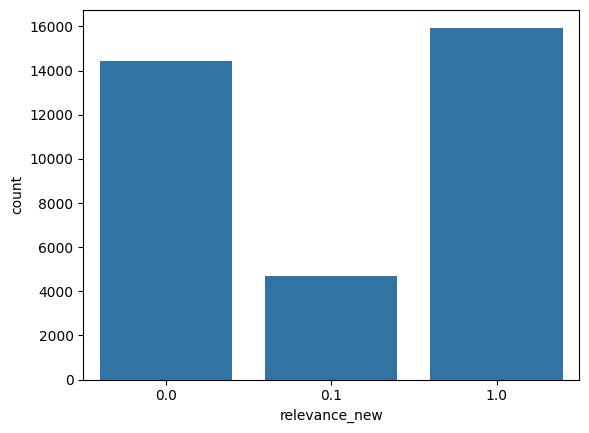

1.0 :15950 (45.45%)
0.1 :4703 (13.40%)
0.0 :14441 (41.15%)


In [ ]:
sns.countplot(data=data, x='relevance_new', )
plt.show()
n = len(data)
minus = len(data[data['relevance_new'] == 0.1])
plus = len(data[data['relevance_new'] == 1.0])
irr = len(data[data['relevance_new'] == 0.0])
print(f"1.0 :{plus} ({plus/n * 100:.2f}%)")
print(f"0.1 :{minus} ({minus/n * 100:.2f}%)")
print(f"0.0 :{irr} ({irr/n * 100:.2f}%)")

#### 2. Распределение классов для каждого заведения

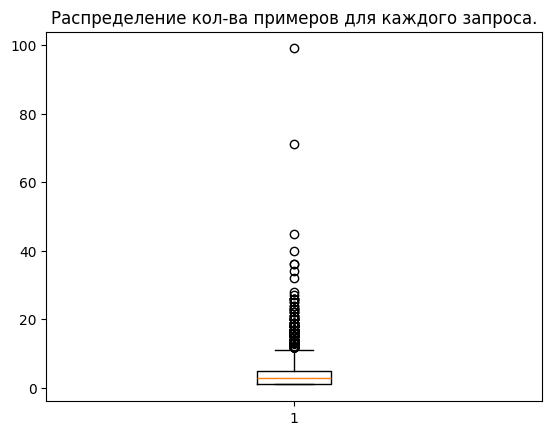

In [ ]:
counts = data.groupby('Text').size().reset_index(name='count')
plt.boxplot(counts['count'])
plt.title("Распределение кол-ва примеров для каждого запроса.")
plt.show()

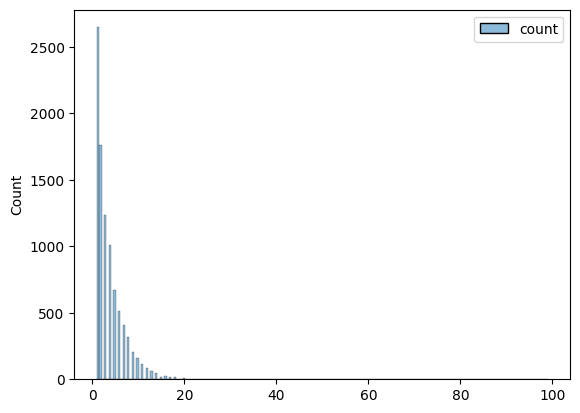

In [ ]:
sns.histplot(data=counts)
plt.show()

# Написание бейзлайна (2 балла)

Что вообще должен из себя представлять бейзлайн?

1) Дообучить Классификатор на трансформере.
2) Тупо запрос в LLM
Реализуем обе этих тактики, посмотрим на результат.


## 1. Дообучение классификатора на трансформере.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1.1 Подготовка данных.

Методы для обработки данных (можно потом перенести в датасет):

In [ ]:
def make_object_text(row):
    return (
        f"Запрос: {row['Text']}. "
        f"Результат: "
        f"Название: {row['name']}\n"
        f"Рубрика: {row['normalized_main_rubric_name_ru']}\n"
        f"Адрес: {row['address']}\n"
        f"Цены: {row['prices_summarized']}\n"
        f"Отзывы: {row['reviews_summarized']}"
    )

document = data.apply(make_object_text, axis=1)

In [ ]:
ind2label = {0:0.0, 1:1.0, 2:0.1}
label2ind = {0.0:0, 1.0:1, 0.1:2}

relevances = data['relevance'].map(label2ind)

Датасет

In [ ]:
class OrgDataset(Dataset):
    def __init__(self, df, relevances, tokenizer, device, max_len):
        # data
        self.data = df.to_list()
        self.targets = relevances.to_list()


    def __getitem__(self, idx):
        # Get text and label for this text
        text = self.data[idx]

        target = self.targets[idx]

        return text, target

    def __len__(self):
        return len(self.data)


class CollateCall:
    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, batch):
        texts, targets = zip(*batch)

        batch_dict = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        targets = torch.tensor(targets, dtype=torch.int32)

Создание датасетов и загрузка модели

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-0.6B', padding_side='left')
model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

# Some imports

In [ ]:
def last_token_pool(last_hidden_states: Tensor,attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]


def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery:{query}'

In [ ]:
# Each query must come with a one-sentence instruction that describes the task
task = 'Given a web search query, retrieve relevant passages that answer the query'

queries = [
    get_detailed_instruct(task, 'What is the capital of China?'),
    get_detailed_instruct(task, 'Explain gravity')
]
# No need to add instruction for retrieval documents
documents = [
    "The capital of China is Beijing.",
    "Gravity is a force that attracts two bodies towards each other. It gives weight to physical objects and is responsible for the movement of planets around the sun."
]
input_texts = queries + documents

tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-0.6B', padding_side='left')
model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B')

# We recommend enabling flash_attention_2 for better acceleration and memory saving.
# model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B', attn_implementation="flash_attention_2", torch_dtype=torch.float16).cuda()

max_length = 8192

# Tokenize the input texts
batch_dict = tokenizer(
    input_texts,
    padding=True,
    truncation=True,
    max_length=max_length,
    return_tensors="pt",
)
batch_dict.to(model.device)
outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T)
print(scores.tolist())
# [[0.7645568251609802, 0.14142508804798126], [0.13549736142158508, 0.5999549627304077]]

[[0.7645567655563354, 0.14142516255378723], [0.13549745082855225, 0.5999547243118286]]


In [ ]:
input_texts = ['Text word', 'Text']
# Tokenize the input texts
batch_dict = tokenizer(
    input_texts,
    padding=True,
    truncation=True,
    max_length=max_length,
    return_tensors="pt",
)
batch_dict

outputs = model(**batch_dict)

In [ ]:
outputs.last_hidden_state[:, -1]

torch.Size([2, 1024])

In [ ]:
attention_mask = batch_dict['attention_mask']

In [ ]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])